# "머신러닝을 통한 접근 가이드" 목차
## 1. Library
## 2. Data Loading
## 3. Feature Engineering
### 3-1. Feature Generation
#### CODE SHARE WITH "파베르"님 
#### (https://dacon.io/competitions/official/235745/codeshare/2851?page=1&dtype=recent)
### 3-2. Feature Engineering
#### 3-2-1. Encoding
#### 3-2-2. Scailing
## 4. Modeling with Pycaret
## 5. Modeling with CatBoostRegressor

## 1. Library

In [1]:
# for "2. Data Loading"
import pandas as pd

# for "3-1. Feature Generation"
import numpy as np

# for "3-2. Feature Engineering"
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import RobustScaler, StandardScaler

# for "4. Modeling with Pycaret"
from pycaret.regression import *

# for "5. Modeling with CatBoostRegressor"
from catboost import CatBoostRegressor
import optuna
from optuna import Trial
from optuna.samplers import TPESampler
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split, StratifiedKFold

## 2. Data Loading

In [2]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

## 3. Feature Engineering

### 3-1. Feature Generation
#### CODE SHARE WITH "파베르"님 
#### (https://dacon.io/competitions/official/235745/codeshare/2851?page=1&dtype=recent)
##### Feature Generation과 관련된 EDA는 위의 링크를 참조해주세요 :) 

In [3]:
train.loc[train.임대보증금=='-', '임대보증금'] = np.nan
test.loc[test.임대보증금=='-', '임대보증금'] = np.nan
train['임대보증금'] = train['임대보증금'].astype(float)
test['임대보증금'] = test['임대보증금'].astype(float)

train.loc[train.임대료=='-', '임대료'] = np.nan
test.loc[test.임대료=='-', '임대료'] = np.nan
train['임대료'] = train['임대료'].astype(float)
test['임대료'] = test['임대료'].astype(float)

train[['임대보증금', '임대료']] = train[['임대보증금', '임대료']].fillna(0)
test[['임대보증금', '임대료']] = test[['임대보증금', '임대료']].fillna(0)

cols = ['도보 10분거리 내 지하철역 수(환승노선 수 반영)', '도보 10분거리 내 버스정류장 수']
train[cols] = train[cols].fillna(0)
test[cols] = test[cols].fillna(0)

#### (3) 자격유형

test.loc[test.단지코드.isin(['C2411']) & test.자격유형.isnull(), '자격유형'] = 'A'
test.loc[test.단지코드.isin(['C2253']) & test.자격유형.isnull(), '자격유형'] = 'C'

train = train.drop_duplicates()
test = test.drop_duplicates()

unique_cols = ['총세대수', '지역', '공가수', 
               '도보 10분거리 내 지하철역 수(환승노선 수 반영)',
               '도보 10분거리 내 버스정류장 수',
               '단지내주차면수', '등록차량수']
train_agg = train.set_index('단지코드')[unique_cols].drop_duplicates()
test_agg = test.set_index('단지코드')[[col for col in unique_cols if col!='등록차량수']].drop_duplicates()

def reshape_cat_features(data, cast_col, value_col):
    res = data.drop_duplicates(['단지코드', cast_col]).assign(counter=1).pivot(index='단지코드', columns=cast_col, values=value_col).fillna(0)
    res.columns.name = None
    res = res.rename(columns={col:cast_col+'_'+col for col in res.columns})
    return res

train.loc[train.공급유형.isin(['공공임대(5년)', '공공분양', '공공임대(10년)', '공공임대(분납)']), '공급유형'] = '공공임대(5년/10년/분납/분양)'
test.loc[test.공급유형.isin(['공공임대(5년)', '공공분양', '공공임대(10년)', '공공임대(분납)']), '공급유형'] = '공공임대(5년/10년/분납/분양)'
train.loc[train.공급유형.isin(['장기전세', '국민임대']), '공급유형'] = '국민임대/장기전세'
test.loc[test.공급유형.isin(['장기전세', '국민임대']), '공급유형'] = '국민임대/장기전세'

train.loc[train.자격유형.isin(['J', 'L', 'K', 'N', 'M', 'O']), '자격유형'] = '행복주택_공급대상'
test.loc[test.자격유형.isin(['J', 'L', 'K', 'N', 'M', 'O']), '자격유형'] = '행복주택_공급대상'

train.loc[train.자격유형.isin(['H', 'B', 'E', 'G']), '자격유형'] = '국민임대/장기전세_공급대상'
test.loc[test.자격유형.isin(['H', 'B', 'E', 'G']), '자격유형'] = '국민임대/장기전세_공급대상'

train.loc[train.자격유형.isin(['C', 'I', 'F']), '자격유형'] = '영구임대_공급대상'
test.loc[test.자격유형.isin(['C', 'I', 'F']), '자격유형'] = '영구임대_공급대상'

X_train = pd.concat([train_agg,
                       reshape_cat_features(data=train, cast_col='임대건물구분', value_col='counter'),
                       reshape_cat_features(data=train, cast_col='공급유형', value_col='counter'),
                       reshape_cat_features(data=train, cast_col='자격유형', value_col='counter')], axis=1)

X_test = pd.concat([test_agg,
                       reshape_cat_features(data=test, cast_col='임대건물구분', value_col='counter'),
                       reshape_cat_features(data=test, cast_col='공급유형', value_col='counter'),
                       reshape_cat_features(data=test, cast_col='자격유형', value_col='counter')], axis=1)

In [8]:
len(X_test), len(test_agg)

(150, 150)

### 3-2. Feature Engineering
- 필요성?

In [4]:
X_train.head(3)

# 1. 지역은 글자데이터이다.
## 한글은 Catboost 이외에는 받아들일 수 없기  때문에, Encoding 과정이 필요하다.
## 해결법  : 통계치를 반영한 Encoding과, One-Hot Encoding 모두 적용해준다.

,총세대수,지역,공가수,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수,임대건물구분_상가,임대건물구분_아파트,공급유형_공공임대(50년),공급유형_공공임대(5년/10년/분납/분양),공급유형_국민임대/장기전세,공급유형_영구임대,공급유형_임대상가,공급유형_행복주택,자격유형_A,자격유형_D,자격유형_국민임대/장기전세_공급대상,자격유형_영구임대_공급대상,자격유형_행복주택_공급대상
단지코드,,,,,,,,,,,,,,,,,,,,
C2483,900,경상북도,38.0,0.0,3.0,1425.0,1015.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
C2515,545,경상남도,17.0,0.0,3.0,624.0,205.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
C1407,1216,대전광역시,13.0,1.0,1.0,1285.0,1064.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [5]:
X_train.describe()

# 2. 단위가 다르다.
## 총 세대수, 공가수는 "세대 수"를, "도보 ~~"는 근처의 "개수"를, "단지내주차면수"는 "면적"을 의미하는 등 의미하는 바가 다르다.
## 이 경우에는, Feature의 "Scale"을 동일하게 해주지 않으면 Machine Learning과정에서 가중치 학습에 있어서 오류가 있을 수 있다.
## 해결법 : Robust Scailing을 적용해준다. (Good for outliers)

# 3. 이상치가 보인다.
## "도보 10분 거리 내 버스정류장 수"를 확인하면, 75%까지는 4이나, max는 20인 것을 확인할 수 있다.
## "도보 10분 거리 내 지하철역~`"은 75%까지는 0이지만, max는 3인 것을 확인할 수 있다.
## 이상치는 Linear Regression Model에서 상대적으로 큰 영향력을 끼친다.
## 해결법 : 데이터를 살펴보고, 처리를 결정한다.

# 4. 의미 없는 Feature도 확인되었다.
## "임대건물구분_아파트"의 경우 모두가 1이다.
## 해결법 : 단순 제거해준다.

,총세대수,공가수,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수,임대건물구분_상가,임대건물구분_아파트,공급유형_공공임대(50년),공급유형_공공임대(5년/10년/분납/분양),공급유형_국민임대/장기전세,공급유형_영구임대,공급유형_임대상가,공급유형_행복주택,자격유형_A,자격유형_D,자격유형_국민임대/장기전세_공급대상,자격유형_영구임대_공급대상,자격유형_행복주택_공급대상
count,423.000000,423.000000,423.000000,423.000000,423.000000,423.000000,423.000000,423.0,423.000000,423.000000,423.000000,423.000000,423.000000,423.000000,423.000000,423.000000,423.000000,423.000000,423.000000
mean,722.387707,13.479905,0.120567,3.690307,592.744681,572.335697,0.078014,1.0,0.026005,0.089835,0.742317,0.132388,0.078014,0.073286,0.784870,0.080378,0.115839,0.130024,0.073286
std,405.590274,10.385414,0.379733,2.808429,367.655143,391.032563,0.268511,0.0,0.159338,0.286283,0.437877,0.339313,0.268511,0.260914,0.411399,0.272200,0.320411,0.336728,0.260914
min,26.000000,0.000000,0.000000,0.000000,13.000000,13.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,447.500000,5.000000,0.000000,2.000000,319.500000,295.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,632.000000,13.000000,0.000000,3.000000,523.000000,505.000000,0.000000,1.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,923.000000,20.000000,0.000000,4.000000,803.000000,762.500000,0.000000,1.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,2568.000000,55.000000,3.000000,20.000000,1798.000000,2550.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [6]:
X_train = X_train.drop(columns = ['임대건물구분_아파트'])
X_test = X_test.drop(columns = ['임대건물구분_아파트'])

- 필요성 - 3. 이상치가 보인다

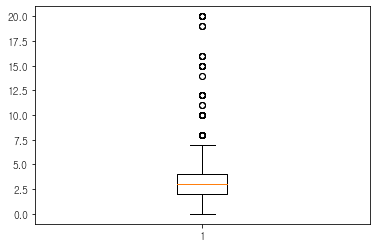

In [7]:
plt.boxplot([train['도보 10분거리 내 버스정류장 수']])
plt.show()

# 20에 가까운 값들이 존재하지만, 따로 처리해주기에는 독립적으로 떨어진 분포가 아니기 때문에, 제거하지 않는다.

In [8]:
display('Train Data')
display(X_train.groupby(['도보 10분거리 내 지하철역 수(환승노선 수 반영)'])['총세대수'].agg('count'))
display('='*50)
display('Test Data')
display(X_test.groupby(['도보 10분거리 내 지하철역 수(환승노선 수 반영)'])['총세대수'].agg('count'))
display('='*50)
# 지하철 역 수가 3인 데이터는 제거한다.

display('After Engineering')
X_train = X_train[X_train['도보 10분거리 내 지하철역 수(환승노선 수 반영)'] != 3]
display(X_train.groupby(['도보 10분거리 내 지하철역 수(환승노선 수 반영)'])['총세대수'].agg('count'))

'Train Data'

도보 10분거리 내 지하철역 수(환승노선 수 반영)
0.0    379
1.0     38
2.0      5
3.0      1
Name: 총세대수, dtype: int64

'=================================================='

'Test Data'

도보 10분거리 내 지하철역 수(환승노선 수 반영)
0.0    139
1.0      8
2.0      3
Name: 총세대수, dtype: int64

'=================================================='

'After Engineering'

도보 10분거리 내 지하철역 수(환승노선 수 반영)
0.0    379
1.0     38
2.0      5
Name: 총세대수, dtype: int64

#### 3-2-1. Encoding

In [9]:
%%time
encoding_features = ['지역', '도보 10분거리 내 지하철역 수(환승노선 수 반영)']

for f in encoding_features:
    mapping = X_train.groupby([f])['등록차량수'].agg(['mean','median','std'])
    mapping_values = []
    for l in X_train[f].values:
        mapping_values.extend([mapping.loc[l].values])
    bincount = pd.DataFrame(mapping_values, columns = [f+'_mean', f+'_median', f+'_std', ], index = X_train.index)
    X_train = pd.concat([X_train,bincount], axis= 1).drop(columns = [f])

    mapping_values = []
    for l in X_test[f].values:
        mapping_values.extend([mapping.loc[l].values])
    bincount = pd.DataFrame(mapping_values, columns = [f+'_mean', f+'_median', f+'_std', ], index = X_test.index)
    X_test = pd.concat([X_test,bincount], axis= 1).drop(columns = [f])

Wall time: 105 ms


#### 3-2-2. Scailing

In [10]:
scailing_features = ['총세대수',
                     '공가수',
                     '도보 10분거리 내 버스정류장 수',
                     '단지내주차면수',
                     '지역_mean', 
                     '지역_median',
                     '지역_std', 
                     '도보 10분거리 내 지하철역 수(환승노선 수 반영)_mean',
                   '도보 10분거리 내 지하철역 수(환승노선 수 반영)_median',
                   '도보 10분거리 내 지하철역 수(환승노선 수 반영)_std'
                    ]

In [11]:
X_train

,총세대수,공가수,도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수,임대건물구분_상가,공급유형_공공임대(50년),공급유형_공공임대(5년/10년/분납/분양),공급유형_국민임대/장기전세,공급유형_영구임대,공급유형_임대상가,공급유형_행복주택,자격유형_A,자격유형_D,자격유형_국민임대/장기전세_공급대상,자격유형_영구임대_공급대상,자격유형_행복주택_공급대상,지역_mean,지역_median,지역_std,도보 10분거리 내 지하철역 수(환승노선 수 반영)_mean,도보 10분거리 내 지하철역 수(환승노선 수 반영)_median,도보 10분거리 내 지하철역 수(환승노선 수 반영)_std
단지코드,,,,,,,,,,,,,,,,,,,,,,,
C2483,900,38.0,3.0,1425.0,1015.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,614.818182,541.5,340.584041,573.963061,505.0,393.050704
C2515,545,17.0,3.0,624.0,205.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,475.418182,479.0,320.611897,573.963061,505.0,393.050704
C1407,1216,13.0,1.0,1285.0,1064.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,647.040000,444.0,543.030039,551.342105,501.5,390.882043
C1945,755,6.0,3.0,734.0,730.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,724.227273,654.5,408.354385,551.342105,501.5,390.882043
C1470,696,14.0,2.0,645.0,553.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,474.095238,415.0,280.481177,573.963061,505.0,393.050704
C1898,566,9.0,6.0,517.0,415.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,474.095238,415.0,280.481177,573.963061,505.0,393.050704
C1244,1722,10.0,10.0,1483.0,1804.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,724.227273,654.5,408.354385,573.963061,505.0,393.050704
C1171,624,13.0,5.0,634.0,700.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,647.040000,444.0,543.030039,573.963061,505.0,393.050704
C2073,361,13.0,5.0,288.0,301.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,385.081081,305.0,247.867951,573.963061,505.0,393.050704


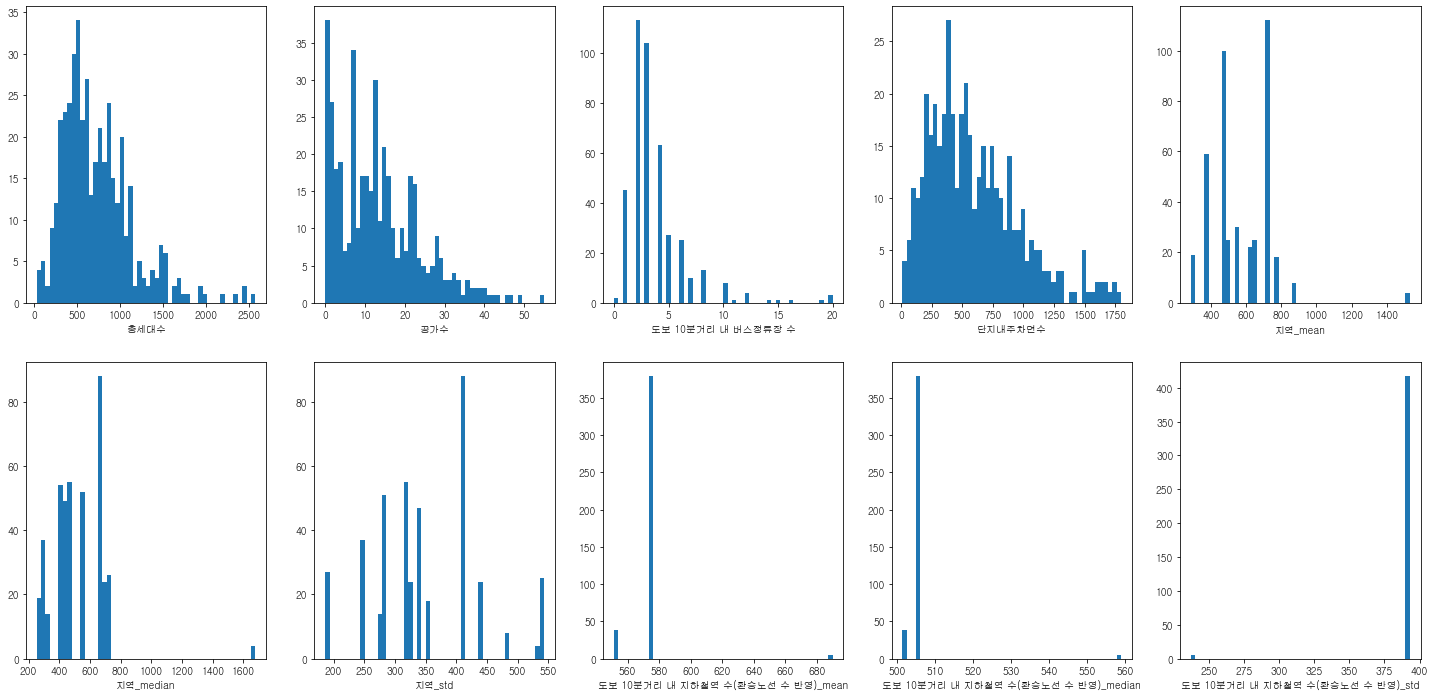

In [12]:
fig, axes = plt.subplots(2,5, figsize= (25,12))

i = 0
for f in scailing_features:
    c = i % 5
    r = int(i // 5)
    plt.subplot(2, 5, i+1)
    plt.hist(x = f, bins =50, data = X_train)
    plt.xlabel(f)
    i += 1
plt.show()


# 지역은 이상치가 확인 => Robust Scailing
# 도보 -> std 제거
# 나머지는 Standard

In [13]:
# 도보 10분거리 std는 그림상 의미가 없기에 Drop
X_train = X_train.iloc[:,:-1]
X_test = X_test.iloc[:,:-1]

In [34]:
# 지역은  Scailing

scaler = RobustScaler()
loc_f = [    '지역_mean', 
             '지역_median',
             '지역_std', ]
X_train.loc[:, loc_f] = scaler.fit_transform(X_train[loc_f])
X_test.loc[:, loc_f] = scaler.transform(X_test[loc_f])

In [15]:
# 나머지 Scailing
scailing_features = ['총세대수',
                     '공가수',
                     '도보 10분거리 내 버스정류장 수',
                     '단지내주차면수',
                     '도보 10분거리 내 지하철역 수(환승노선 수 반영)_mean',
                       '도보 10분거리 내 지하철역 수(환승노선 수 반영)_median',
                    ]

scaler = StandardScaler()
X_train.loc[:, scailing_features] = scaler.fit_transform(X_train[scailing_features])
X_test.loc[:, scailing_features] = scaler.transform(X_test[scailing_features])

## 4. Modeling with pycaret

In [16]:
reg = setup(X_train, 
            preprocess = False, # True로 설정되면, 자체적인 Feature Engineering을 추가로 진행해 Predict가 불가능해진다.
            train_size = 0.999,  # 우리는 전체 데이터를 학습해 test를 예측하는게 목표이기 때문에, 0.999로 설정한다.
            target = '등록차량수', # 목표 변수는 등록 차량 수 이다.
            silent = True, # 엔터를 누르기 귀찮다. 궁금하면 풀어보세요
            use_gpu = True, # GPU가 있으면 사용하세요 (Cat BOost 속도 향상)
            numeric_features=list(X_train.drop(columns = ['등록차량수']).columns), # 모든 변수가 숫자로써의 의미가 있다.
            session_id = 2021,
            fold_shuffle = True
            )

,Description,Value
0,session_id,2021
1,Target,등록차량수
2,Original Data,"(422, 22)"
3,Missing Values,False
4,Numeric Features,21
5,Categorical Features,0
6,Transformed Train Set,"(421, 21)"
7,Transformed Test Set,"(1, 21)"
8,Shuffle Train-Test,True
9,Stratify Train-Test,False


- Top5의 모델 선택

In [17]:
top5 = compare_models(n_select = 5, sort = 'MAE')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,125.1988,35508.2233,185.6443,0.7474,0.3896,0.3522,1.3750
huber,Huber Regressor,126.5474,33222.8917,179.8276,0.7673,0.4071,0.3645,0.0240
par,Passive Aggressive Regressor,126.9502,34187.2766,182.0227,0.7621,0.4418,0.3844,0.0050
br,Bayesian Ridge,127.7621,34035.5342,182.3251,0.7599,0.4352,0.3557,0.0060
llar,Lasso Least Angle Regression,127.9068,34727.1605,183.1723,0.7592,0.4076,0.3883,0.0060
ridge,Ridge Regression,127.9770,33995.0404,182.2432,0.7600,0.4410,0.3584,0.0050
lasso,Lasso Regression,128.0406,33796.4854,181.6456,0.7618,0.4290,0.3545,0.0070
lr,Linear Regression,128.8471,34048.5254,182.3509,0.7598,0.4525,0.3649,0.0060
gbr,Gradient Boosting Regressor,129.1675,36619.8012,189.2337,0.7361,0.3936,0.3443,0.0560
rf,Random Forest Regressor,129.1792,37307.4262,190.7672,0.7337,0.3714,0.3289,0.6390


- Top5 Model Tuning

In [19]:
models = []
for m in top5:
    models.append(tune_model(m, 
                             optimize = 'MAE', 
                             choose_better = True,
                            n_iter = 30))

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,137.5499,36979.9343,192.3017,0.7484,0.4535,0.4424
1,128.0842,32811.2479,181.1388,0.7957,0.4916,0.4016
2,152.6469,41475.6063,203.6556,0.7335,0.4716,0.4308
3,128.6503,30093.5153,173.4748,0.8090,0.4945,0.2738
4,116.0907,22820.4473,151.0644,0.7901,0.3327,0.2772
5,142.9697,43961.5047,209.6700,0.7688,0.3738,0.3014
6,104.8039,24934.6603,157.9071,0.7802,0.3209,0.3180
7,146.0293,55390.1752,235.3512,0.7936,0.3172,0.2428
8,115.8168,29118.6280,170.6418,0.6757,0.3606,0.3342
9,100.6862,17864.2532,133.6572,0.7424,0.5731,0.5034


In [20]:
voting = blend_models(models, optimize = 'MAE')
voting = tune_model(voting, 
                 optimize = 'MAE', 
                 choose_better = True,
                 n_iter = 30)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,131.3579,31577.6939,177.7011,0.7851,0.4934,0.4960
1,120.9144,31772.0725,178.2472,0.8022,0.4308,0.3849
2,147.4441,40908.8371,202.2593,0.7371,0.4607,0.3936
3,121.6844,27506.1720,165.8498,0.8254,0.2777,0.2270
4,116.7556,21877.9817,147.9121,0.7988,0.3100,0.2655
5,137.3282,45210.3718,212.6273,0.7622,0.3628,0.2920
6,103.0668,24711.7057,157.1996,0.7822,0.3162,0.2723
7,140.4412,54139.8920,232.6798,0.7983,0.2746,0.2222
8,113.6496,29064.8440,170.4841,0.6763,0.3804,0.3500
9,95.6767,16685.1487,129.1710,0.7594,0.4955,0.5161


In [21]:
sample = pd.read_csv('./data/sample_submission.csv')
layer1_pred = voting.predict(X_test)
sample['num'] = layer1_pred
# sample.to_csv('../submissions/pycaret.csv', index=False)

In [32]:
X_test

,총세대수,공가수,도보 10분거리 내 버스정류장 수,단지내주차면수,임대건물구분_상가,공급유형_공공임대(50년),공급유형_공공임대(5년/10년/분납/분양),공급유형_국민임대/장기전세,공급유형_영구임대,공급유형_임대상가,...,자격유형_A,자격유형_D,자격유형_국민임대/장기전세_공급대상,자격유형_영구임대_공급대상,자격유형_행복주택_공급대상,지역_mean,지역_median,지역_std,도보 10분거리 내 지하철역 수(환승노선 수 반영)_mean,도보 10분거리 내 지하철역 수(환승노선 수 반영)_median
단지코드,,,,,,,,,,,,,,,,,,,,,
C1072,0.075523,0.053028,-0.601617,0.243566,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.690063,0.732777,0.552273,0.046453,-0.054451
C1128,1.556840,-0.429250,-0.245541,1.694733,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.690063,0.732777,0.552273,0.046453,-0.054451
C1456,-0.257774,0.438850,4.383448,-0.126712,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,-0.263555,-0.162839,-0.144629,0.046453,-0.054451
C1840,-0.321964,-0.622161,-0.245541,-0.137603,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,-0.315254,-0.267223,-0.482600,0.046453,-0.054451
C1332,1.416114,-0.236339,-0.601617,1.411578,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.690063,0.732777,0.552273,0.046453,-0.054451
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C2456,-0.924366,0.342394,0.110535,-0.880883,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,-0.727886,-0.628392,-0.522481,0.046453,-0.054451
C1266,-0.314558,2.078594,-0.957693,-0.001471,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.000000,0.252610,-0.447727,0.046453,-0.054451
C2152,-1.489736,-0.429250,-0.957693,-1.507090,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,-0.673015,-0.726514,-0.746538,0.046453,-0.054451


In [22]:
sample

,code,num
0,C1072,668.796733
1,C1128,1146.470654
2,C1456,552.198453
3,C1840,530.853966
4,C1332,1027.511424
...,...,...
145,C2456,229.341480
146,C1266,455.094592
147,C2152,-13.992167
148,C1267,317.881162


# Modeling with Gradient Boosting Regressor

- Setting Data For Model

In [23]:
X = X_train.drop(columns = ['등록차량수'])
y = X_train['등록차량수']

- Hyper params Tuning

In [24]:
def objective(trial: Trial) -> float:
    params_cat = {
        "random_state": 42,
        "learning_rate": 0.05,
        "n_estimators": 10000,
        "verbose" : 1,
        "objective" : "MAE",
        "max_depth": trial.suggest_int("max_depth", 1, 16),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.8, 1.0),
        "subsample": trial.suggest_float("subsample", 0.3, 1.0),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "max_bin": trial.suggest_int("max_bin", 200, 500),
    }
    
    X_tr, X_val, y_tr, y_val = train_test_split(X, y, test_size=0.2)

    model = CatBoostRegressor(**params_cat)
    model.fit(
        X_tr,
        y_tr,
        eval_set=[(X_tr, y_tr), (X_val, y_val)],
        early_stopping_rounds=10,
        verbose=False,
    )

    cat_pred = model.predict(X_val)
    log_score = mean_absolute_error(y_val, cat_pred)
    
    return log_score

In [25]:
sampler = TPESampler(seed=42)
study = optuna.create_study(
    study_name="cat_opt",
    direction="minimize",
    sampler=sampler,
)
study.optimize(objective, n_trials=10)
print("Best Score:", study.best_value)
print("Best trial:", study.best_trial.params)

[I 2021-07-24 13:19:11,430] A new study created in memory with name: cat_opt
[I 2021-07-24 13:19:11,654] Trial 0 finished with value: 105.91353046023015 and parameters: {'max_depth': 6, 'colsample_bylevel': 0.9901428612819833, 'subsample': 0.8123957592679836, 'min_child_samples': 62, 'max_bin': 246}. Best is trial 0 with value: 105.91353046023015.
[I 2021-07-24 13:19:11,782] Trial 1 finished with value: 130.72515336025955 and parameters: {'max_depth': 3, 'colsample_bylevel': 0.8116167224336399, 'subsample': 0.9063233020424546, 'min_child_samples': 62, 'max_bin': 413}. Best is trial 0 with value: 105.91353046023015.
[I 2021-07-24 13:19:11,958] Trial 2 finished with value: 151.1029762434 and parameters: {'max_depth': 1, 'colsample_bylevel': 0.9939819704323989, 'subsample': 0.8827098485602951, 'min_child_samples': 25, 'max_bin': 254}. Best is trial 0 with value: 105.91353046023015.
[I 2021-07-24 13:19:12,126] Trial 3 finished with value: 119.33794473628764 and parameters: {'max_depth': 3,

Best Score: 105.91353046023015
Best trial: {'max_depth': 6, 'colsample_bylevel': 0.9901428612819833, 'subsample': 0.8123957592679836, 'min_child_samples': 62, 'max_bin': 246}


In [26]:
cat_p = study.best_trial.params
cat = CatBoostRegressor(**cat_p)

In [27]:
y

단지코드
C2483    1015.0
C2515     205.0
C1407    1064.0
C1945     730.0
C1470     553.0
          ...  
C2586      57.0
C2035     246.0
C2020      19.0
C2437      16.0
C2532     146.0
Name: 등록차량수, Length: 422, dtype: float64

In [28]:
y_cat = pd.cut(x=y, bins=10, labels=range(10))
y_cat

단지코드
C2483    3
C2515    0
C1407    4
C1945    2
C1470    2
        ..
C2586    0
C2035    0
C2020    0
C2437    0
C2532    0
Name: 등록차량수, Length: 422, dtype: category
Categories (10, int64): [0 < 1 < 2 < 3 ... 6 < 7 < 8 < 9]

In [29]:
skf = StratifiedKFold(5)

for tr, val in skf.split(X, y_cat):
    print('Tr :\n', tr, '\nVal :\n', val)

Tr :
 [ 33  34  35  37  38  39  43  44  47  49  50  51  52  53  56  58  59  61
  62  63  64  66  67  68  69  70  71  77  79 104 107 111 112 113 114 115
 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134 135 136 137
 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155
 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173
 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191
 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209
 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227
 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245
 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263
 264 265 266 267 268 269 270 271 272 273 274 275 276 277 278 279 280 281
 282 283 284 285 286 287 288 289 290 291 292 293 294 295 296 297 298 299
 300 301 302 303 304 305 306 307 308 309 310 311 312 313 314 315 316 317
 318 319 321 322 323 324 325 326 327 328 329 

- StratifiedK-Fold for Regression

In [30]:
y_cat = pd.cut(y, 10, labels=range(10))
skf = StratifiedKFold(5)

preds = []
for tr_id, val_id in skf.split(X, y_cat) : 
    X_tr = X.iloc[tr_id]
    y_tr = y.iloc[tr_id]
    
    cat.fit(X_tr, y_tr, verbose = 0)
    
    pred = cat.predict(X_test)
    preds.append(pred)
cat_pred = np.mean(preds, axis = 0)

In [31]:
sample = pd.read_csv('../data/sample_submission.csv')
sample['num'] = cat_pred
sample.to_csv('../submissions/cat.csv', index=False)

FileNotFoundError: [Errno 2] No such file or directory: '../data/sample_submission.csv'